In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import sys
sys.path.append("../scripts/")  # Add the scripts folder to the path

import utils as util
import eda

c:\Users\Tsebaot\Desktop\week 1\financial-news-prediction-analysis\venv\lib\site-packages\nltk\metrics\association.py:26: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.stats import fisher_exact


In [2]:
# Load datasets
all_data_path1 = '../data/raw_analyst_ratings.csv'
all_data_path2 = '../data/AAPL_historical_data.csv'
news_data = util.read_csv_file(all_data_path1)
stock_data = util.read_csv_file(all_data_path2)
news_data = news_data.get("data")
stock_data = stock_data.get("data")

# Display the first few rows of each dataset
print(news_data.head())
print(stock_data.head())

                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:0

In [3]:
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

In [4]:
news_data['date'] = pd.to_datetime(news_data['date'], utc=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True)

In [5]:
print(news_data['date'].head())
print(stock_data['Date'].head())

0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
0   1980-12-12 00:00:00+00:00
1   1980-12-15 00:00:00+00:00
2   1980-12-16 00:00:00+00:00
3   1980-12-17 00:00:00+00:00
4   1980-12-18 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


In [6]:
news_data['date'] = news_data['date'].dt.tz_localize(None)
stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)

In [7]:
print(news_data['date'].head())
print(stock_data['Date'].head())

0   2020-06-05 14:30:54
1   2020-06-03 14:45:20
2   2020-05-26 08:30:07
3   2020-05-22 16:45:06
4   2020-05-22 15:38:59
Name: date, dtype: datetime64[ns]
0   1980-12-12
1   1980-12-15
2   1980-12-16
3   1980-12-17
4   1980-12-18
Name: Date, dtype: datetime64[ns]


In [8]:
# Set the date as the index for easy alignment
news_data.set_index('date', inplace=True)
stock_data.set_index('Date', inplace=True)

# Display the first few rows to confirm alignment
print(news_data.head())
print(stock_data.head())


                                                              headline  \
date                                                                     
2020-06-05 14:30:54            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07                      71 Biggest Movers From Friday   
2020-05-22 16:45:06       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59  B of A Securities Maintains Neutral on Agilent...   

                                                                   url  \
date                                                                     
2020-06-05 14:30:54  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03 14:45:20  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26 08:30:07  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22 16:45:06  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22 15:38:59  https://www.benz

In [9]:
# Function to calculate sentiment score
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

# Apply sentiment analysis to the headlines
news_data['sentiment'] = news_data['headline'].apply(get_sentiment)


# Reset the index to prepare for aggregation
news_data.reset_index(inplace=True)


In [22]:
news_data.head()

,date,headline,url,publisher,stock,sentiment
0,2020-06-05 14:30:54,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,0.0
1,2020-06-03 14:45:20,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,0.0
2,2020-05-26 08:30:07,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,0.0
3,2020-05-22 16:45:06,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,0.0
4,2020-05-22 15:38:59,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,0.0


In [11]:
# Calculate daily returns
stock_data['daily_return'] = stock_data['Close'].pct_change()
stock_data.dropna(inplace=True)  # Drop NA values that result from the pct_change


In [12]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,daily_return
Date,,,,,,,,,
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0,-0.052171
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0,-0.073398
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600,0.0,0.0,0.024751
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600,0.0,0.0,0.028992
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097223,48630400,0.0,0.0,0.061029


In [17]:
stock_data.reset_index(inplace=True)
print(stock_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'daily_return'],
      dtype='object')


In [64]:
# Ensure 'Date' exists in stock_data
if 'Date' not in stock_data.columns:
    stock_data.reset_index(inplace=True)  # Reset index if Date is the index

# Align on date columns
stock_data.set_index('Date', inplace=True)  # Ensure correct date index
aapl_news = news_data[news_data['stock'] == 'AAPL'].copy()  # Filter AAPL news

# Join the sentiment data with stock prices
combined_data = aapl_news.set_index('date').join(stock_data['Close'])

# Display the combined data
print(combined_data.head())

                                                     headline  \
2020-03-09  Crude Awakening: Energy Sector Takes A 20% Spi...   
2020-03-09     Investor Movement Index Summary: February 2020   
2020-03-09      101 Stocks Moving In Monday's Mid-Day Session   
2020-03-10  Peloton Shares Tick To Session Low As Hearing ...   
2020-03-10                  Morning Market Stats In 5 Minutes   

                                                          url  \
2020-03-09  https://www.benzinga.com/news/earnings/20/03/1...   
2020-03-09  https://www.benzinga.com/news/earnings/20/03/1...   
2020-03-09  https://www.benzinga.com/news/20/03/15508983/1...   
2020-03-10  https://www.benzinga.com/news/20/03/15519796/p...   
2020-03-10  https://www.benzinga.com/news/20/03/15517906/m...   

                    publisher stock  sentiment      Close  
2020-03-09         JJ Kinahan  AAPL  -0.466667  66.542503  
2020-03-09      TD Ameritrade  AAPL   0.000000  66.542503  
2020-03-09         Lisa Levin  AAPL   

In [53]:
print(stock_data.columns)  # Check available columns
print(stock_data.index)    # Check if the index contains the 'Date' information

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'daily_return'],
      dtype='object')
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004',
               '1970-01-01 00:00:00.000000005',
               '1970-01-01 00:00:00.000000006',
               '1970-01-01 00:00:00.000000007',
               '1970-01-01 00:00:00.000000008',
               '1970-01-01 00:00:00.000000009',
               ...
               '1970-01-01 00:00:00.000010987',
               '1970-01-01 00:00:00.000010988',
               '1970-01-01 00:00:00.000010989',
               '1970-01-01 00:00:00.000010990',
               '1970-01-01 00:00:00.000010991',
               '1970-01-01 00:00:00.000010992',
               '1970-01-01 00:00:00.000010993',
               '1970

In [56]:
# Ensure the index is datetime and named correctly
if not isinstance(stock_data.index, pd.DatetimeIndex):
    stock_data.index = pd.to_datetime(stock_data.index)  # Convert to datetime if necessary
stock_data.index.name = 'Date'  # 

In [57]:
# Ensure the index is datetime and named correctly
if not isinstance(combined_data.index, pd.DatetimeIndex):
   combined_data .index = pd.to_datetime(combined_data.index)  # Convert to datetime if necessary
combined_data.index.name = 'date'  # 

In [60]:
print(combined_data.columns)
print(combined_data.index)

Index(['level_0', 'headline', 'url', 'publisher', 'stock', 'sentiment',
       'Close', 'daily_return'],
      dtype='object')
DatetimeIndex(['2020-03-09 00:00:00', '2020-03-09 00:00:00',
               '2020-03-09 00:00:00', '2020-03-10 00:00:00',
               '2020-03-10 00:00:00', '2020-03-10 00:00:00',
               '2020-03-10 00:00:00', '2020-03-10 00:00:00',
               '2020-03-10 00:00:00', '2020-03-10 00:00:00',
               ...
               '2020-06-09 15:11:34', '2020-06-09 16:41:02',
               '2020-06-09 17:58:46', '2020-06-09 19:14:07',
               '2020-06-10 04:52:01', '2020-06-10 10:27:11',
               '2020-06-10 11:19:25', '2020-06-10 11:53:47',
               '2020-06-10 12:14:08', '2020-06-10 15:33:26'],
              dtype='datetime64[ns]', name='date', length=441, freq=None)


In [61]:
combined_data.drop(columns=['level_0'], inplace=True, errors='ignore')  # Safely drop 'level_0'

In [62]:
# Ensure stock_data has a DateTime index
stock_data.index = pd.to_datetime(stock_data.index)  # Convert index to datetime if needed
stock_data.set_index('Date', inplace=True, drop=False)  # Ensure 'Date' is the index


In [68]:
''' combined_data.drop(columns=['daily_return'], inplace=True, errors='ignore')
combined_data = combined_data.join(stock_data['daily_return'])

#combined_data = combined_data.join(stock_data['daily_return'])
print(combined_data.head()) '''

# Drop the existing 'daily_return' column if it already exists
if 'daily_return' in combined_data.columns:
    combined_data.drop(columns=['daily_return'], inplace=True)

# Join the 'daily_return' column from stock_data
combined_data = combined_data.join(stock_data['daily_return'])

# Verify the result
print(combined_data.head())


                                                     headline  \
2020-03-09  Crude Awakening: Energy Sector Takes A 20% Spi...   
2020-03-09     Investor Movement Index Summary: February 2020   
2020-03-09      101 Stocks Moving In Monday's Mid-Day Session   
2020-03-10  Peloton Shares Tick To Session Low As Hearing ...   
2020-03-10                  Morning Market Stats In 5 Minutes   

                                                          url  \
2020-03-09  https://www.benzinga.com/news/earnings/20/03/1...   
2020-03-09  https://www.benzinga.com/news/earnings/20/03/1...   
2020-03-09  https://www.benzinga.com/news/20/03/15508983/1...   
2020-03-10  https://www.benzinga.com/news/20/03/15519796/p...   
2020-03-10  https://www.benzinga.com/news/20/03/15517906/m...   

                    publisher stock  sentiment      Close  daily_return  
2020-03-09         JJ Kinahan  AAPL  -0.466667  66.542503     -0.079092  
2020-03-09      TD Ameritrade  AAPL   0.000000  66.542503     -0.07909

In [ ]:
# Calculate correlation
correlation = combined_data['sentiment'].corr(combined_data['daily_return'])
print("Correlation between sentiment and daily stock returns:", correlation)


Correlation between sentiment and daily stock returns: 0.06122464414879541


In [71]:
correlation = combined_data['sentiment'].corr(combined_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: 0.027105118291747842


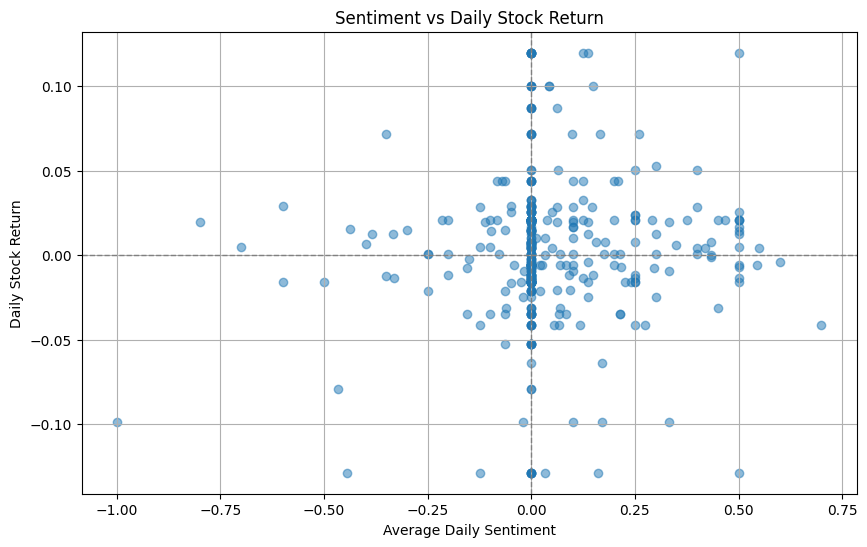

In [72]:
# Scatter plot for sentiment vs daily return
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['sentiment'], combined_data['daily_return'], alpha=0.5)
plt.title('Sentiment vs Daily Stock Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Return')
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')
plt.grid()
plt.show()